In [114]:
# Use preview feature of Power Query to check data first.
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import data
df = pd.read_excel(r"D:\Project RFM\Sales_info.xlsx", index_col=0)
print(df)


       InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  \
0         536365    85123A         7 2021-12-03 08:26:00       2.61   
1         536365     71053         7 2021-12-03 08:26:00       3.45   
2         536365    84406B         9 2021-12-03 08:26:00       2.81   
3         536365    84029G         7 2021-12-03 08:26:00       3.45   
4         536365    84029E         7 2021-12-03 08:26:00       3.45   
...          ...       ...       ...                 ...        ...   
541801    581578     22993        13 2022-12-11 12:16:00       1.31   
541802    581578     22907        13 2022-12-11 12:16:00       0.91   
541803    581578     22908        13 2022-12-11 12:16:00       0.91   
541804    581578     23215        13 2022-12-11 12:16:00       2.14   
541805    581578     22736        11 2022-12-11 12:16:00       1.71   

        CustomerID        Country  
0          17850.0          China  
1          17850.0          China  
2          17850.0          China  
3  

In [115]:
# Check null
num_null_rows = df.isnull().sum()
print(num_null_rows)

# Only column CustomerID contains null value. We only focus on the known customers so we will drop all null values. 
# However, the number of null accounts for 25% so it should be investigated more carefully in another analysis.

InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134502
Country             0
dtype: int64


In [116]:
# Drop rows that contain null
df_not_null = df[df['CustomerID'].notna()]

# Drop duplicate rows and keep the first occurrence
df_not_dup = df_not_null.drop_duplicates()

China            515323
United States     17554
USA                 291
Name: Country, dtype: int64


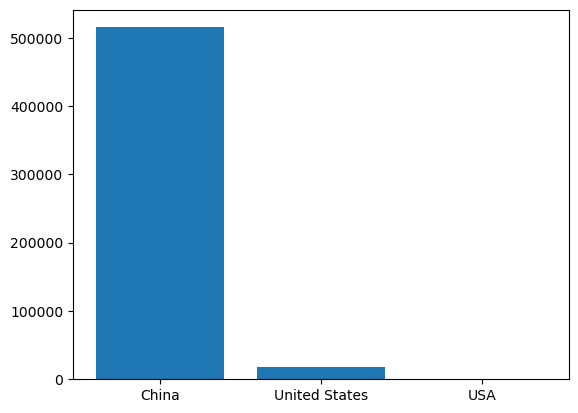

In [117]:
# Check distribution of the column country
country_counts = df['Country'].value_counts()
print(country_counts)
plt.bar(country_counts.index, country_counts.values)
plt.show()


In [118]:
# Filter Chinese customers only
#-------Make sure that there are no negative values in quantity column and unit price column

df_cleaned=df_cn.loc[ df_not_dup['Quantity'] > 0  , :]
df_cleaned2=df_cn.loc[ df_not_dup['UnitPrice'] > 0  , :]

df_cn=df_cleaned2.loc[df_not_dup['Country'] == 'China'   , : ]
df_cn=df_cn.copy()
print(df_cn)

       InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  \
0         536365    85123A         7 2021-12-03 08:26:00       2.61   
1         536365     71053         7 2021-12-03 08:26:00       3.45   
2         536365    84406B         9 2021-12-03 08:26:00       2.81   
3         536365    84029G         7 2021-12-03 08:26:00       3.45   
4         536365    84029E         7 2021-12-03 08:26:00       3.45   
...          ...       ...       ...                 ...        ...   
541904    581587     22613        13 2022-12-11 12:50:00       0.91   
541905    581587     22899         7 2022-12-11 12:50:00       2.16   
541906    581587     23254         5 2022-12-11 12:50:00       4.21   
541907    581587     23255         5 2022-12-11 12:50:00       4.21   
541908    581587     22138         4 2022-12-11 12:50:00       5.01   

        CustomerID Country  TotalPay  
0          17850.0   China     18.27  
1          17850.0   China     24.15  
2          17850.0   China    

In [119]:
# Calculate RFM

In [120]:
# --Calculate R - Recency
# ----Check column InvoiceDate
df_cn['InvoiceDate'].describe 

<bound method NDFrame.describe of 0        2021-12-03 08:26:00
1        2021-12-03 08:26:00
2        2021-12-03 08:26:00
3        2021-12-03 08:26:00
4        2021-12-03 08:26:00
                 ...        
541904   2022-12-11 12:50:00
541905   2022-12-11 12:50:00
541906   2022-12-11 12:50:00
541907   2022-12-11 12:50:00
541908   2022-12-11 12:50:00
Name: InvoiceDate, Length: 367660, dtype: datetime64[ns]>

In [121]:
#-----InvoiceDate is now string, not datetime type 
df_cn['InvoiceDate'] =  pd.to_datetime(df_cn['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')

# Since the last day of the dataset is 2 months earlier than the real current date, will we regard this very last day as the current date.
import datetime
current_date = max(df_cn['InvoiceDate']) + datetime.timedelta(days=1)



In [122]:
# -------- Calculate M - MoneytaryValue
df_cn['TotalPay'] = df_cn['Quantity'] * df_cn['UnitPrice']

# Group by CustomerID to calculate Recency, Frequency, Monetary Value

df_cn_cus = df_cn.groupby(['CustomerID']).agg(
    {'InvoiceDate': lambda x: (current_date- x.max()).days,
     'InvoiceNo':'count',
     'TotalPay':'sum'
    }
)
print(df_cn_cus)

            InvoiceDate  InvoiceNo  TotalPay
CustomerID                                  
12346.0             326          1  81637.60
12349.0              19         73   2404.89
12357.0              33        131   6816.68
12371.0              45         63   2171.28
12377.0             315         77   1898.73
...                 ...        ...       ...
18280.0             278         10    231.55
18281.0             181          7    123.84
18282.0               8         12    247.34
18283.0               4        721   3344.54
18287.0              43         70   2041.19

[4048 rows x 3 columns]


In [123]:
# Rename the columns
df_cn_cus.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPay':'MonetaryValue'}, inplace=True)

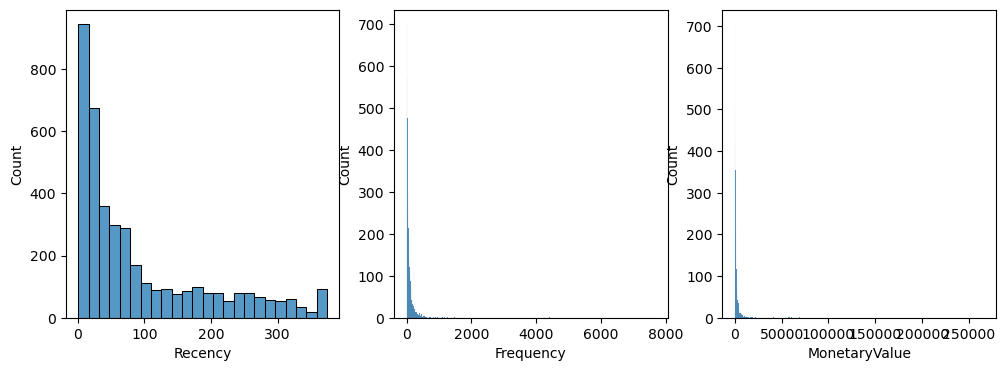

In [124]:
# Use graph to check distribution

fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.histplot(df_cn_cus['Recency'], ax = ax[0])
sns.histplot(df_cn_cus['Frequency'], ax = ax[1])
sns.histplot(df_cn_cus['MonetaryValue'], ax = ax[2])
plt.show()

In [125]:
# Transform data so that they have Standard Normal Distribution form.
#-------Firstly, check what method of transformation is the most effective for out dataset.
from scipy import stats
import seaborn as sns

def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(df_cn_cus[x], ax=ax[0,0])
    sns.histplot(np.log(df_cn_cus[x]), ax=ax[0,1])  #Log Transformation
    sns.histplot(np.sqrt(df_cn_cus[x]), ax=ax[1,0]) #Square Root Transformation
    sns.histplot(stats.boxcox(df_cn_cus[x])[0], ax=ax[1,1]) #Boxcox Transformation
    plt.tight_layout()
    plt.show()
    
    print(df_cn_cus[x].skew().round(2))  
    print(np.log(df_cn_cus[x]).skew().round(2))  
    print(np.sqrt(df_cn_cus[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_cn_cus[x])[0]).skew().round(2))
   

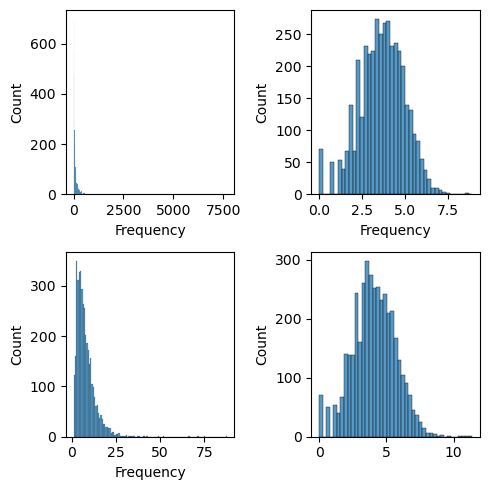

18.09
-0.22
3.28
0.0


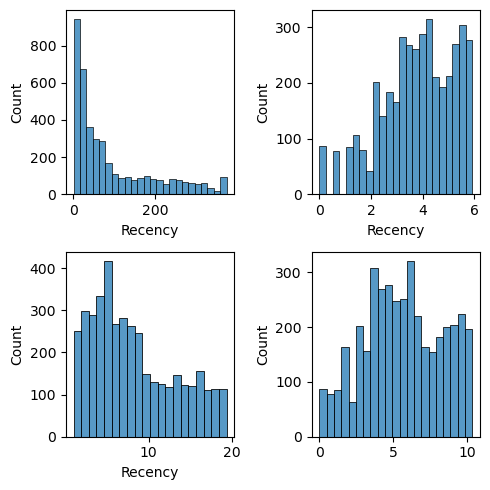

1.25
-0.55
0.59
-0.07


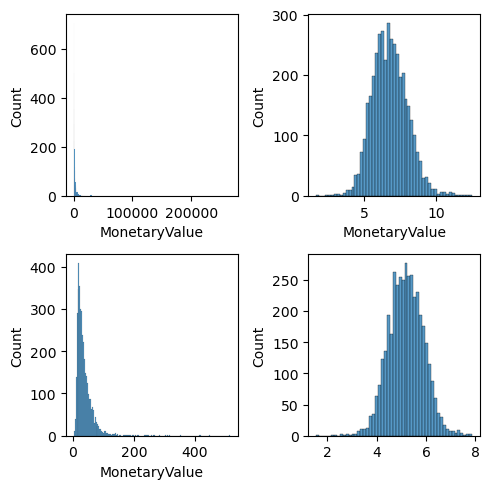

17.27
0.35
5.17
-0.01


In [126]:
analyze_skewness('Frequency')
analyze_skewness('Recency')
analyze_skewness('MonetaryValue')
df_transformed = pd.DataFrame()
#-------> Through cheking, we find out that boxcox is the most effective transformation (The last graph)

In [127]:
df_transformed['Recency'] = stats.boxcox(df_cn_cus['Recency'])[0]
df_transformed['Frequency'] = stats.boxcox(df_cn_cus['Frequency'])[0]
df_transformed['MonetaryValue'] = pd.Series(np.cbrt(df_cn_cus['MonetaryValue'])).values


df_transformed.head(10)

,Recency,Frequency,MonetaryValue
0,9.979921,0.000000,43.380719
1,3.845177,4.808273,13.397746
2,4.812044,5.550880,18.960843
3,5.397366,4.624717,12.949071
4,9.886309,4.875087,12.382863
5,7.655821,6.222448,16.903653
6,4.577359,3.595987,9.310906
7,5.440054,4.999379,12.372093
8,6.543516,5.314949,22.767597
9,9.834104,3.551214,9.554698


In [128]:
# Scale Data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_transformed)

df_transformed = scaler.transform(df_transformed)


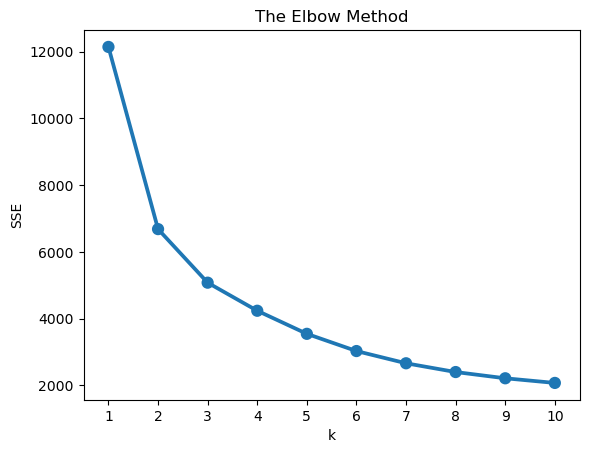

In [129]:
# Choose suitable number of clusters by Kmeans with ELBOW method

from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_transformed)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [130]:

model = KMeans(n_clusters=3, random_state=42)
model.fit(df_transformed)

df_cn_cus['Cluster'] = model.labels_
     

In [131]:

df_cn_cus.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'MonetaryValue':'mean'
    }
).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,43.06,65.62,1264.88
1,182.54,18.78,449.45
2,19.75,313.42,8964.24


In [132]:
#CONCLUSION
# Group 0: Normal Customer
# Group 1: Likely-to-churn customers
# Group 2: Loyal Customer
